In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [2]:
PROJECT_ROOT = Path.cwd().parent
DATA_PATH = PROJECT_ROOT / "dataset" / "train_FD001.csv"

print("Dataset path:", DATA_PATH)

Dataset path: c:\Users\venut\OneDrive\Desktop\predictive_maintenance\dataset\train_FD001.csv


In [3]:
df = pd.read_csv(DATA_PATH)
df.head()

,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


#### Engine Lifetime Analysis

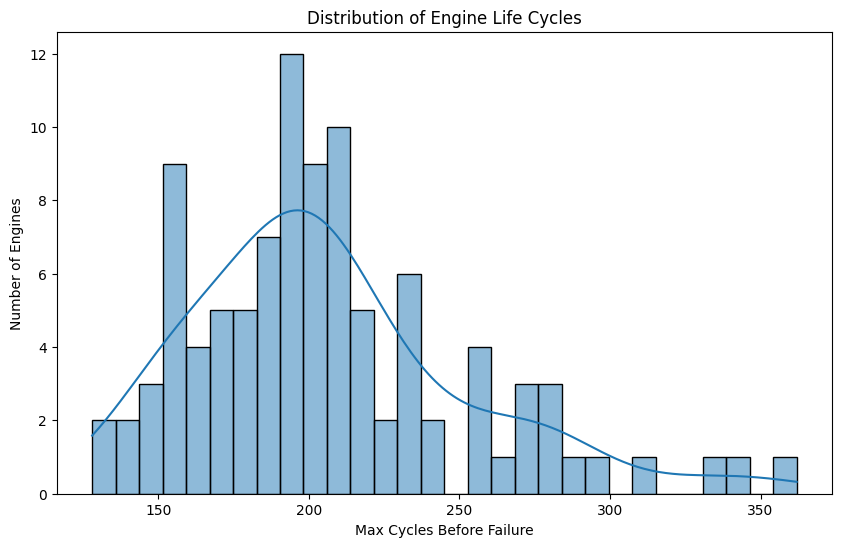

In [4]:
engine_life = df.groupby("engine_id")["cycle"].max()

plt.figure(figsize=(10, 6))
sns.histplot(engine_life, bins = 30, kde = True)
plt.title("Distribution of Engine Life Cycles")
plt.xlabel("Max Cycles Before Failure")
plt.ylabel("Number of Engines")
plt.show()

The distribution of engine life cycles shows significant variability and right skewness, indicating heterogeneous degradation behavior across engines. This validates the need for predictive maintenance models that estimate Remaining Useful Life instead of relying on fixed maintenance thresholds.

#### Sensor Behavior Over Time

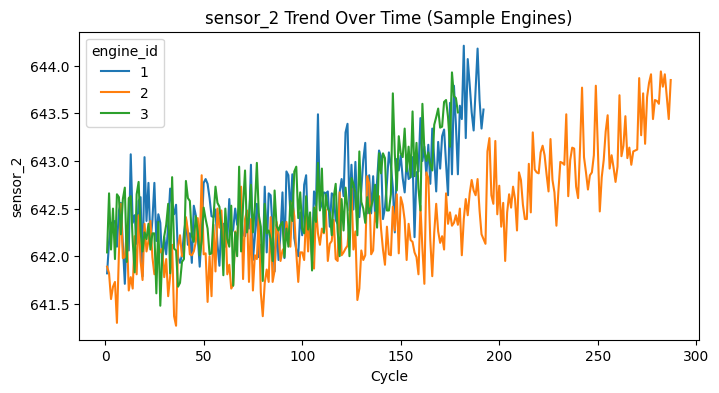

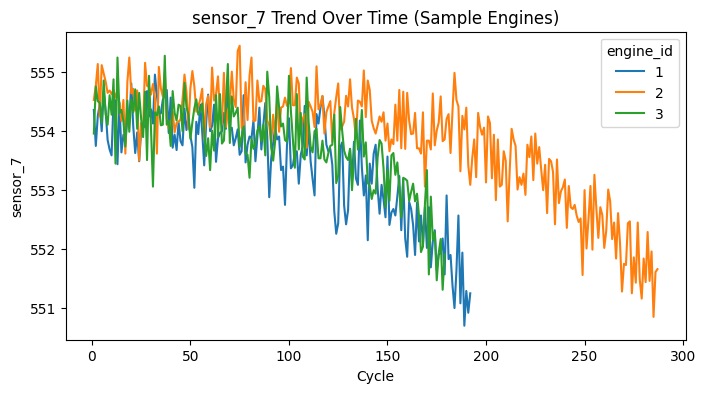

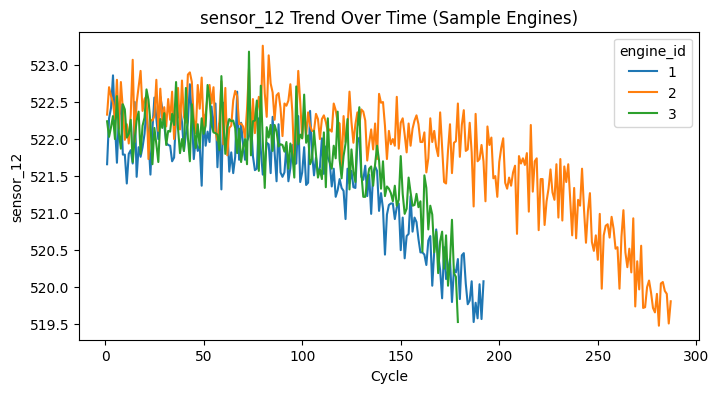

In [5]:
sample_engines = df[df["engine_id"] <= 3]

sensors_to_plot = ["sensor_2", "sensor_7", "sensor_12"]

for sensor in sensors_to_plot:
    pivot = sample_engines.pivot(
        index="cycle",
        columns="engine_id",
        values=sensor
    )
    
    pivot.plot(figsize=(8,4))
    plt.title(f"{sensor} Trend Over Time (Sample Engines)")
    plt.xlabel("Cycle")
    plt.ylabel(sensor)
    plt.show()

Time-series plots of key sensors across sample engines reveal gradual degradation trends with engine-specific variability. Sensors like sensor_2 show smooth temporal drift, making them useful inputs when combined with other sensors for Remaining Useful Life prediction.

From EDA, we observed that certain sensors (notably sensor_7 and sensor_12) exhibit clear monotonic degradation patterns as the engine approaches failure. These sensors show strong correlation with engine life cycles and are therefore suitable for Remaining Useful Life (RUL) prediction. Other sensors such as sensor_2 remain relatively stable and are less indicative of failure but may provide contextual operational information.

In [6]:
sensor_cols = [col for col in df.columns if col.startswith("sensor")]
sensor_variance = df[sensor_cols].std().sort_values()
sensor_variance

sensor_1     0.000000e+00
sensor_10    0.000000e+00
sensor_19    0.000000e+00
sensor_18    0.000000e+00
sensor_16    3.469531e-18
sensor_5     5.329200e-15
sensor_6     1.388985e-03
sensor_15    3.750504e-02
sensor_8     7.098548e-02
sensor_13    7.191892e-02
sensor_21    1.082509e-01
sensor_20    1.807464e-01
sensor_11    2.670874e-01
sensor_2     5.000533e-01
sensor_12    7.375534e-01
sensor_7     8.850923e-01
sensor_17    1.548763e+00
sensor_3     6.131150e+00
sensor_4     9.000605e+00
sensor_14    1.907618e+01
sensor_9     2.208288e+01
dtype: float64

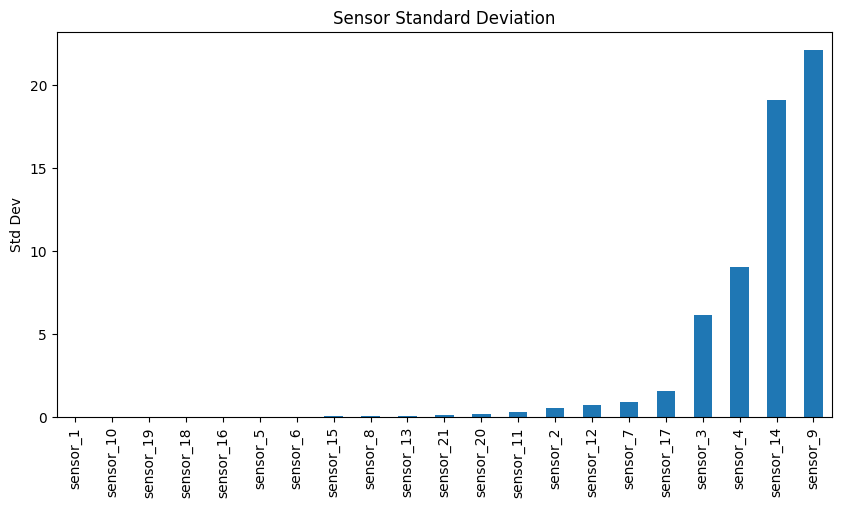

In [7]:
plt.figure(figsize=(10,5))
sensor_variance.plot(kind="bar")
plt.title("Sensor Standard Deviation")
plt.ylabel("Std Dev")
plt.show()

I analyzed sensor variance to identify non-informative features. Several sensors showed zero or near-zero variance and were removed, as they provide no degradation signal. Sensors with higher variance and consistent temporal trends were retained for modeling, improving both model performance and stability

In [8]:
drop_sensors = [
    "sensor_1", "sensor_5", "sensor_10",
    "sensor_16", "sensor_18", "sensor_19"
]

df = df.drop(columns=drop_sensors)

#### Correlation Analysis


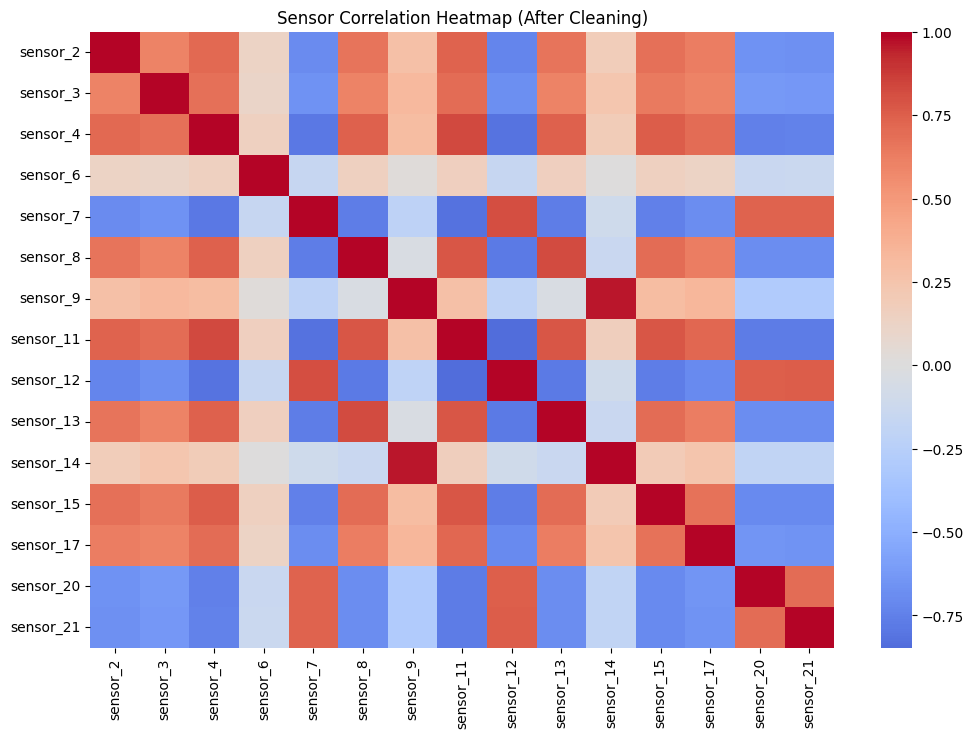

In [9]:
sensor_cols_clean = [c for c in df.columns if c.startswith("sensor")]

plt.figure(figsize=(12,8))
sns.heatmap(
    df[sensor_cols_clean].corr(),
    cmap="coolwarm",
    center=0
)
plt.title("Sensor Correlation Heatmap (After Cleaning)")
plt.show()

#### Remaining Useful Life (RUL)

In [10]:
max_cycle = df.groupby("engine_id")["cycle"].transform("max")
df["RUL"] = max_cycle - df["cycle"]

df[["engine_id", "cycle", "RUL"]].head()

,engine_id,cycle,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


#### RUL Distribution

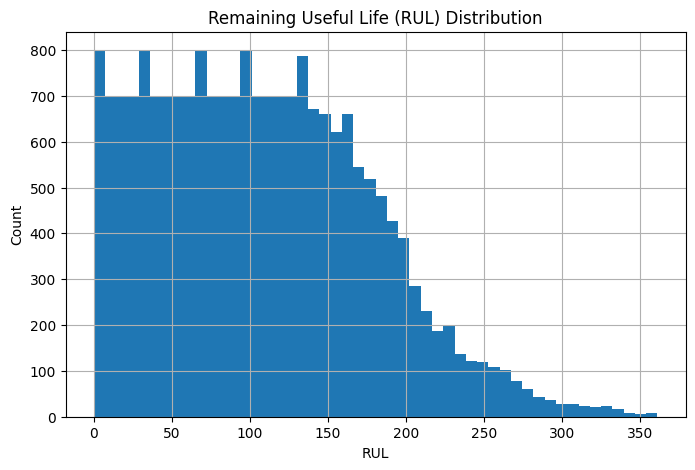

In [11]:
plt.figure(figsize=(8,5))
df["RUL"].hist(bins=50)
plt.title("Remaining Useful Life (RUL) Distribution")
plt.xlabel("RUL")
plt.ylabel("Count")
plt.show()

The RUL distribution is right-skewed with a high concentration of samples near failure. To reduce variance and improve learning stability, RUL capping is applied, which is a standard practice in predictive maintenance.

#### Sensor Trends vs RUL

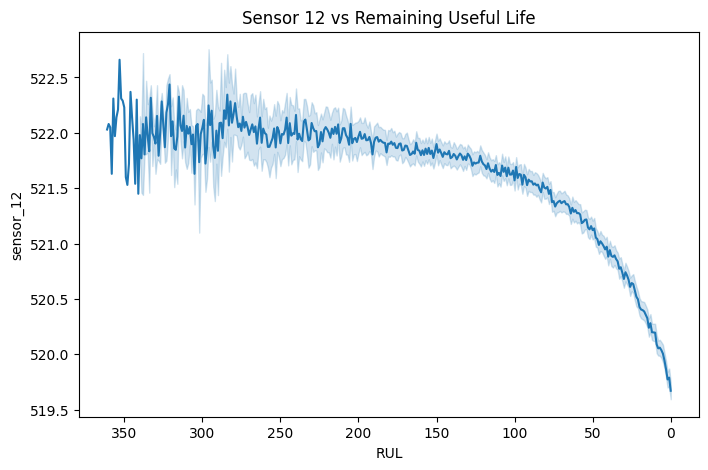

In [12]:
plt.figure(figsize=(8,5))
sns.lineplot(data=df, x="RUL", y="sensor_12")
plt.title("Sensor 12 vs Remaining Useful Life")
plt.gca().invert_xaxis()
plt.show()

Sensor 12 exhibits a clear degradation trend as RUL decreases, making it a strong predictive feature for remaining useful life estimation. The smooth monotonic decline indicates progressive wear behavior.

#### Outlier Detection


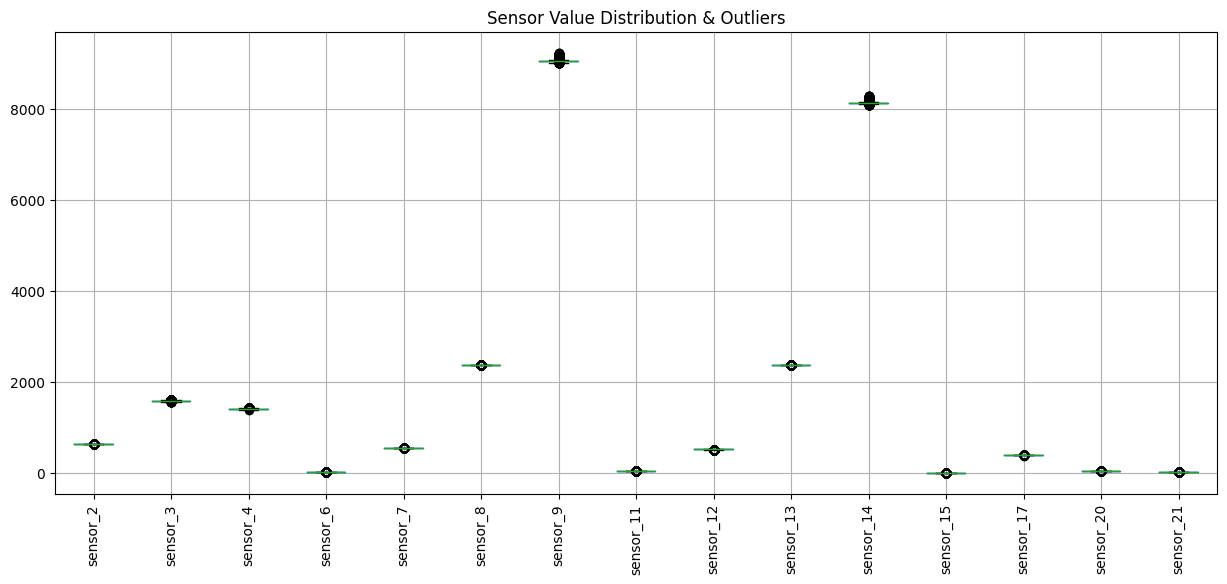

In [14]:
plt.figure(figsize=(15,6))
df[sensor_cols_clean].boxplot()
plt.xticks(rotation=90)
plt.title("Sensor Value Distribution & Outliers")
plt.show()

#### Operating Conditions Effect

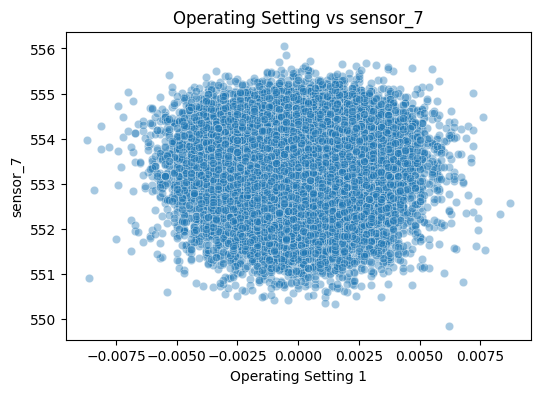

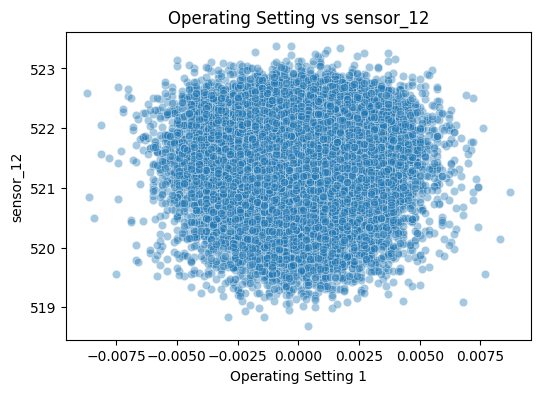

In [15]:
important_sensors = ["sensor_7", "sensor_12"]

for sensor in important_sensors:
    plt.figure(figsize=(6,4))
    sns.scatterplot(
        data=df,
        x="op_setting_1",
        y=sensor,
        alpha=0.4
    )
    plt.title(f"Operating Setting vs {sensor}")
    plt.xlabel("Operating Setting 1")
    plt.ylabel(sensor)
    plt.show()


sensor_7 is suitable for predictive modeling without heavy adjustment for operating conditions.

sensor_12 is a stable and reliable degradation sensor for modeling.

Since both sensor_7 and sensor_12 show no strong dependency on operating settings, the model can:

> Focus primarily on sensor degradation patterns

> Avoid complex operating-condition normalization

> Generalize better across different engine runs